In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import requests
import re
import pandas_profiling
pd.options.display.max_rows=999
pd.options.display.max_columns=999
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import missingno as msno
from pandas_profiling import ProfileReport

In [2]:
# 출처: 위키피디아 - 중앙선거여론조사심의위원회

source_url = "https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EC%A7%80%EC%A7%80%EC%9C%A8"
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html,'lxml')
contents_table = soup.find(name="table", attrs={"class":"wikitable"} )
table_body = contents_table.find(name="tbody")
table_data = pd.DataFrame(table_body.text.replace("\n", " ").split("  "))
table_data = table_data.drop(table_data.index[0:300]).reset_index(drop=True)

table_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       176 non-null    object
dtypes: object(1)
memory usage: 1.5+ KB


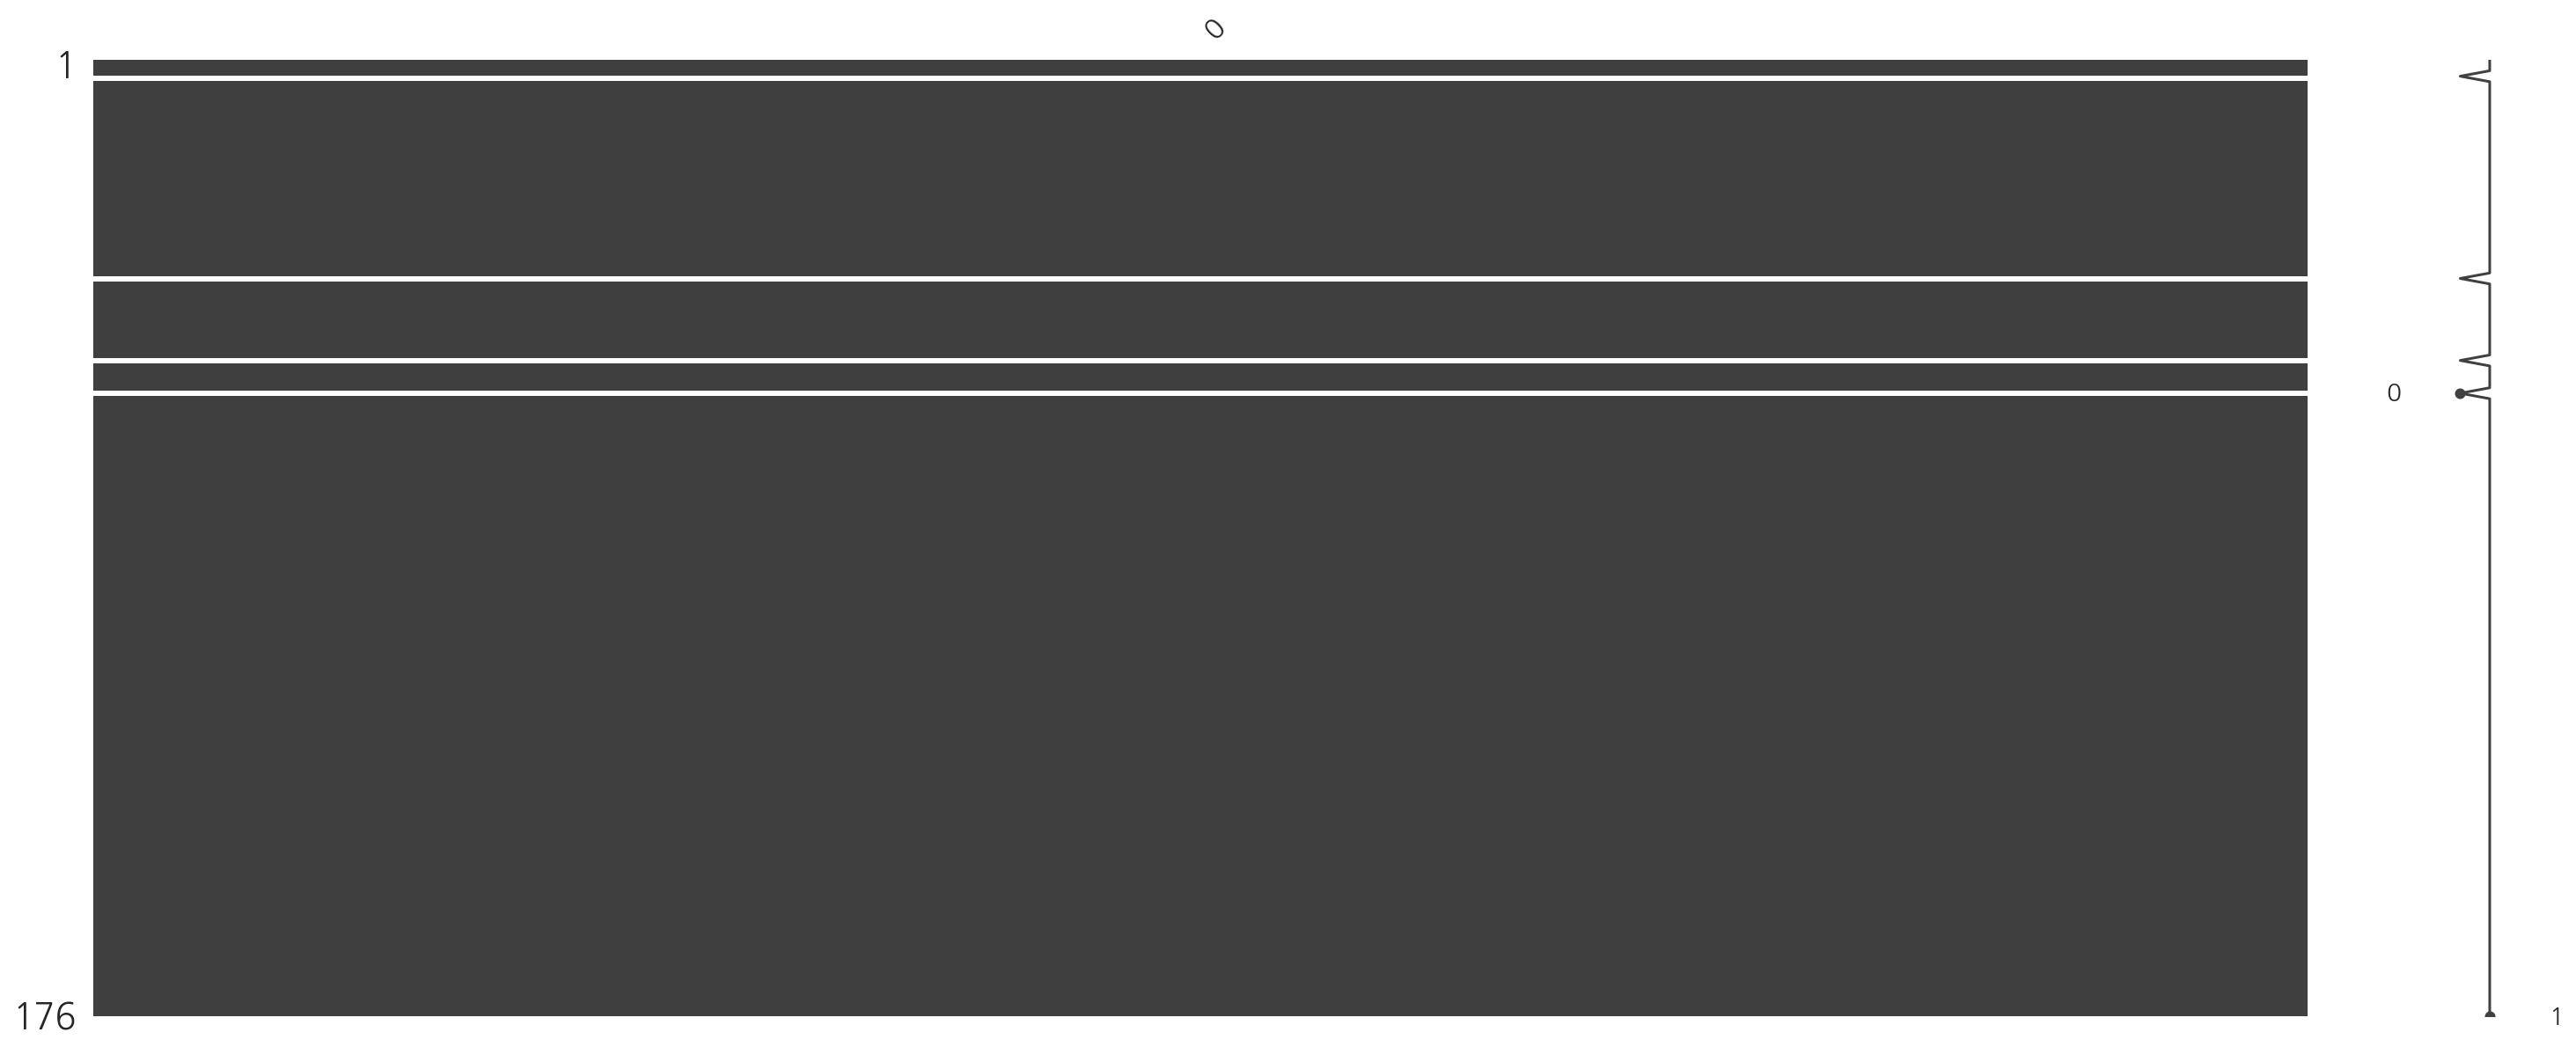

In [3]:
#결측값 : NaN = 미조사

table_data[table_data[0].str.match(pat="미조사")==True] = np.nan

msno.matrix(table_data)

In [4]:
#행열 수 보정을 위한 NaN(= 미조사) 값 추가.

def add_nan(df, a):
    df.loc[a]=np.nan

ls = [0.5, 11.5, 13.5, 40]

for x in ls :
    add_nan(table_data, x)
    
table_data.sort_index(inplace=True)

data_table = []
def data_index(data):   
    for idx in range(0,len(data)):
        if idx%3 ==0:
            k = data.values[idx:idx+3]
            data_table.append(k)
data_index(table_data)

In [5]:
# 리스트 데이터 차원 수 조절을 위한 listcomprehention

data_table = [item for sublist in data_table for item in sublist]
data_table = [item for sublist in data_table for item in sublist]
data_table = pd.Series(data_table)[9:].reset_index(drop=True)
data_table = data_table[:-8]

In [6]:
datas = {}
datas["주차"] = []
datas["한국 갤럽"] = []
datas["리얼미터"] = []
for idx in range(len(data_table)):
    if idx%3 == 0:
        datas["주차"].append(data_table[idx])
    if idx%3 == 1:
        datas["한국 갤럽"].append(data_table[idx])
    if idx%3 == 2:
        datas["리얼미터"].append(data_table[idx])
        
datas_research = pd.DataFrame(datas)

In [7]:
# 주차 조정을 위해 1월 1주차 조사 시작일을 1월 1일로 수정.

idx_2 = datas_research.index%3 == 2 

datas_research = datas_research.loc[datas_research.index[idx_2]]
datas_research["조사 시작일"] =  ["2020-01-01", "2020-01-06","2020-01-13","2020-01-20","2020-01-28",
                                "2020-02-03","2020-02-10","2020-02-17","2020-02-25",
                                "2020-03-02","2020-03-09","2020-03-16","2020-03-23",
                                "2020-03-30","2020-04-06","2020-04-13","2020-04-20","2020-04-27"]

In [8]:
# 오차율 계산

datas_research_mean= datas_research.drop([2,11])[["한국 갤럽","리얼미터"]].reset_index(drop = True)



datas_research_mean["한국 갤럽"] = datas_research_mean["한국 갤럽"].apply(lambda x: "{}".format(str(x)[0:4])).astype("float")
datas_research_mean["리얼미터"]= datas_research_mean["리얼미터"].apply(lambda x: "{}".format(str(x)[0:4])).astype("float")                             
mean_1 = datas_research_mean["한국 갤럽"]
mean_2 = datas_research_mean["리얼미터"]

print("====================")
print(mean_1/mean_2)

# 평균 오차율 : 약 4.6% 

# 1월 1주차 - 2월 3주차 까지 리얼미터가 한국 갤럽보다 지지율에 대해 긍정적으로 평가. 


# 미조사(NaN) 값 :  1월 1주차, 1월 3주차

datas_research.loc[2]["한국 갤럽"] = str(100*round(0.490*(1-np.abs(1-mean_1/mean_2).mean()),1))+"%"
datas_research.loc[11]["한국 갤럽"] = str(100*round(0.470*(1-np.abs(1-mean_1/mean_2).mean()),1))+"%"
datas_research.reset_index(drop=True, inplace= True)

0     0.963115
1     0.993377
2     0.911111
3     0.938166
4     0.944206
5     0.949367
6     0.911063
7     0.918580
8     1.038136
9     0.993915
10    1.045627
11    1.042831
12    1.047794
13    1.012007
14    0.973312
15    1.056106
dtype: float64


In [9]:
# 표본 통합 및 통합 지지율

datas_research["한국 갤럽 표본 수"] = [ 1000 for _ in range(len(datas_research["한국 갤럽"])) ]
datas_research["리얼미터 표본 수"] = [" " for _ in range(len(datas_research["리얼미터"]))]
datas_research["리얼미터 표본 수"].loc[:4] = 2511
datas_research["리얼미터 표본 수"].loc[5:8] = 2520
datas_research["리얼미터 표본 수"].loc[9:12] = 2531
datas_research["리얼미터 표본 수"].loc[13:] = 1509


datas_research["한국 갤럽"] = datas_research["한국 갤럽"].apply(lambda x: "{}".format(str(x)[0:4])).astype("float")
datas_research["리얼미터"] = datas_research["리얼미터"].apply(lambda x: "{}".format(str(x)[0:4])).astype("float")
datas_research["한국 갤럽 표본 수"] = datas_research["한국 갤럽 표본 수"].astype("float")
datas_research["리얼미터 표본 수"] = datas_research["리얼미터 표본 수"].astype("float")

Sample_A = datas_research["한국 갤럽"]
Sample_B = datas_research["리얼미터"]
rate_A = datas_research["한국 갤럽"]
rate_B = datas_research["리얼미터"]

datas_research["통합 지지율"] = round((Sample_A*rate_A + Sample_B*rate_B)/(Sample_A+Sample_B),1)
datas_research["총 표본 수"] = datas_research["리얼미터 표본 수"] + datas_research["한국 갤럽 표본 수"]
datas_research.tail()

,주차,한국 갤럽,리얼미터,조사 시작일,한국 갤럽 표본 수,리얼미터 표본 수,통합 지지율,총 표본 수
13,2020년 4월 1주,56.0,53.7,2020-03-30,1000.0,1509.0,54.9,2509.0
14,2020년 4월 2주,57.0,54.4,2020-04-06,1000.0,1509.0,55.7,2509.0
15,2020년 4월 3주,59.0,58.3,2020-04-13,1000.0,1509.0,58.7,2509.0
16,2020년 4월 4주,62.0,63.7,2020-04-20,1000.0,1509.0,62.9,2509.0
17,2020년 4월 5주,64.0,60.6,2020-04-27,1000.0,1509.0,62.3,2509.0


### 데이콘

#### 한국 확진자 및 사망자

In [11]:
time = pd.read_csv("coronavirusdataset\\Time.csv")
search_trend = pd.read_csv("coronavirusdataset\\SearchTrend.csv")

In [12]:
# Time의 누적확진자 수
confirmed_data = time[['date', 'confirmed','deceased']]
# 누적 확진자 수의 변화량 = 일일 확진자 수
daily_confirmed = (np.r_[0, np.diff(confirmed_data['confirmed'])]/1).astype('int')
daily_deceased = (np.r_[0, np.diff(confirmed_data['deceased'])]/1).astype('int')
confirmed_data['일일확진자(한)'] = daily_confirmed
confirmed_data['일일사망자(한)'] = daily_deceased

In [13]:
# confirmed_data를 2020년 1월 1일부터 2020년 4월 29일까지 기간 동안 모든 데이터를 생성
date_data = pd.DataFrame()
date_data["date"] = pd.date_range("2020-01-01", "2020-04-29")
# date_data와 confirmed_data의 confirmed_date의 자료형을 동일하게 만듬
confirmed_data["date"] =  pd.to_datetime(confirmed_data["date"])
# confrimed_data와 date_data를 merge
confirmed_data = date_data.merge(confirmed_data, how = 'outer')
# NaN = 확진자가 없는 날짜 : 일일 확진자 수(dayofconfirmed )= 0
confirmed_data.fillna(value = 0, inplace=True)

#merge 후 데이터 타입이 float로 변환됨 -> int형으로 다시 변환
confirmed_data = confirmed_data.astype({"일일확진자(한)":'int'})
confirmed_data = confirmed_data.astype({'일일사망자(한)':'int'})
confirmed_data = confirmed_data.astype({'deceased':'int'})
confirmed_data = confirmed_data.astype({"confirmed":'int'})
confirmed_data.rename(columns = {'confirmed':'누적확진자'}, inplace = True)
confirmed_data.rename(columns = {'deceased':'누적사망자'}, inplace = True)
confirmed_data.rename(columns = {'date':'날짜'}, inplace = True)
confirmed_data.tail()

,날짜,누적확진자,누적사망자,일일확진자(한),일일사망자(한)
116,2020-04-26,10728,242,10,2
117,2020-04-27,10738,243,10,1
118,2020-04-28,10752,244,14,1
119,2020-04-29,10761,246,9,2
120,2020-04-30,10765,247,4,1


#### 미국, 중국 일일 확진자 및 사망자 수

In [14]:
# 중국 일일감염자 수와 사망자 수
chn_df = pd.read_csv("owid-covid-data.csv")
chn_df = chn_df[chn_df["iso_code"] == 'CHN']
chn_df = chn_df[(chn_df['date'] < '2020-05-01') & (chn_df['date'] >= '2020-01-01')]
chn_df = chn_df[['date','new_cases','new_deaths']]
chn_df.rename(columns = {'new_cases':'일일확진자(중)', 'new_deaths':'일일사망자(중)'}, inplace = True)
chn_df.reset_index(drop=True, inplace=True)
chn_df.tail()

,date,일일확진자(중),일일사망자(중)
116,2020-04-26,10,0
117,2020-04-27,3,1
118,2020-04-28,26,0
119,2020-04-29,2,0
120,2020-04-30,4,0


In [15]:
# 미국 일일감염자 수와 사망자 수
usa_df = pd.read_csv("owid-covid-data.csv")
usa_df = usa_df[usa_df["iso_code"] == 'USA']
usa_df = usa_df[(usa_df['date'] < '2020-05-01') & (usa_df['date']>= '2020-01-01')]
usa_df = usa_df[["date",'new_cases','new_deaths']]
usa_df.rename(columns = {'new_cases':'일일확진자(미)', 'new_deaths':'일일사망자(미)'}, inplace = True)
usa_df.reset_index(drop=True, inplace=True)
usa_df.tail()

,date,일일확진자(미),일일사망자(미)
116,2020-04-26,48529,2172
117,2020-04-27,26857,1687
118,2020-04-28,22541,1369
119,2020-04-29,24132,2110
120,2020-04-30,27326,2611


In [16]:
# confirmed_data에 미, 중 데이터 추가
confirmed_data['일일확진자(미)'] = usa_df['일일확진자(미)']
confirmed_data['일일사망자(미)'] = usa_df['일일사망자(미)']
confirmed_data['일일확진자(중)'] = chn_df['일일확진자(중)']
confirmed_data['일일사망자(중)'] = chn_df['일일사망자(중)']

In [17]:
# confirmed_data에 코로나 검색량 데이터 추가
search_trend = search_trend[search_trend["date"] > "2020-00-00"]
search_trend.reset_index(drop=True, inplace=True)
confirmed_data["search_trend"] = search_trend["coronavirus"]
confirmed_data.tail()

,날짜,누적확진자,누적사망자,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중),search_trend
116,2020-04-26,10728,242,10,2,48529,2172,10,0,3.95342
117,2020-04-27,10738,243,10,1,26857,1687,3,1,4.11033
118,2020-04-28,10752,244,14,1,22541,1369,26,0,3.73088
119,2020-04-29,10761,246,9,2,24132,2110,2,0,3.78952
120,2020-04-30,10765,247,4,1,27326,2611,4,0,NaN


In [18]:
corona_data = confirmed_data[["날짜", "search_trend",
                              "일일확진자(한)", "일일사망자(한)",
                              "일일확진자(미)", "일일사망자(미)",
                              "일일확진자(중)", "일일사망자(중)"]]
corona_data.reset_index(drop=True, inplace=True)
corona_data.drop(index=120, inplace=True)

In [19]:
corona_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   날짜            120 non-null    datetime64[ns]
 1   search_trend  120 non-null    float64       
 2   일일확진자(한)      120 non-null    int32         
 3   일일사망자(한)      120 non-null    int32         
 4   일일확진자(미)      120 non-null    int64         
 5   일일사망자(미)      120 non-null    int64         
 6   일일확진자(중)      120 non-null    int64         
 7   일일사망자(중)      120 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(4)
memory usage: 7.5 KB


### 지지율

#### 국내 대통령 지지율

In [20]:
# 통합 지지율을 일일 지지율 데이터로 변환
rate_T = datas_research["통합 지지율"].apply(lambda x: "{}".format(str(x)[0:4])).astype("float")
rate_T.index = [idx*7 for idx in range(18)]

rate_T_frame = rate_T.to_frame()
corona_dataframe = corona_data["날짜"].to_frame()
corona_dataframe.index = corona_dataframe.index.astype('int')

daily_rate = corona_dataframe.merge(rate_T_frame, left_index = True, right_index= True, how='outer')

# 선호도 일일 단위로 표시
def fill_data(df, col):
    # 주간 통합 지지율의 변화량
    diff_rate_T = np.r_[0, np.diff(rate_T_frame['통합 지지율'])]/1
    diff_rate_T = np.around(diff_rate_T, decimals=1)

    for idx in range(len(df)):
        # idx % 7 == 0 -> 주간 통합 지지율 조사일
        if idx % 7 == 0 :
            num = df.loc[idx][col]
        # idx % 7 != 0 -> 조사하지 않은 일 = data : NaN
        else :
            num += diff_rate_T[idx // 7 + 1] / 7
            df.loc[idx, col] = round(num, 2)
    return df
fill_data(daily_rate, "통합 지지율")
rate_T = daily_rate["통합 지지율"]

#### 미국 대통령 지지율

In [21]:
usa_data = pd.read_csv("approval_topline.csv")[{"approve_estimate", 'modeldate'}][:384][2::3][::-1].reset_index(drop = True)
#데이터셋에서 all poll 기준으로 평균 지지율을 DATA_usa로 잡음
usa_data.rename(columns = {'modeldate':'날짜', 'approve_estimate':'미국지지율'}, inplace = True)
usa_data["미국지지율"] = round(usa_data['미국지지율'], 2)
usa_data = usa_data[usa_data["날짜"] < '5/01/2020']
usa_data.drop(index = 120, inplace=True)
usa_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   미국지지율   120 non-null    float64
 1   날짜      120 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [22]:
daily_rate['미국지지율'] = usa_data['미국지지율']
daily_rate.rename(columns={'통합 지지율': '한국지지율'}, inplace=True)
daily_rate.describe()

,한국지지율,미국지지율
count,120.000000,120.000000
mean,49.833333,43.404250
std,5.995164,1.151717
min,43.100000,40.570000
25%,45.300000,42.632500
50%,47.505000,43.335000
75%,54.627500,44.052500
max,62.900000,46.330000


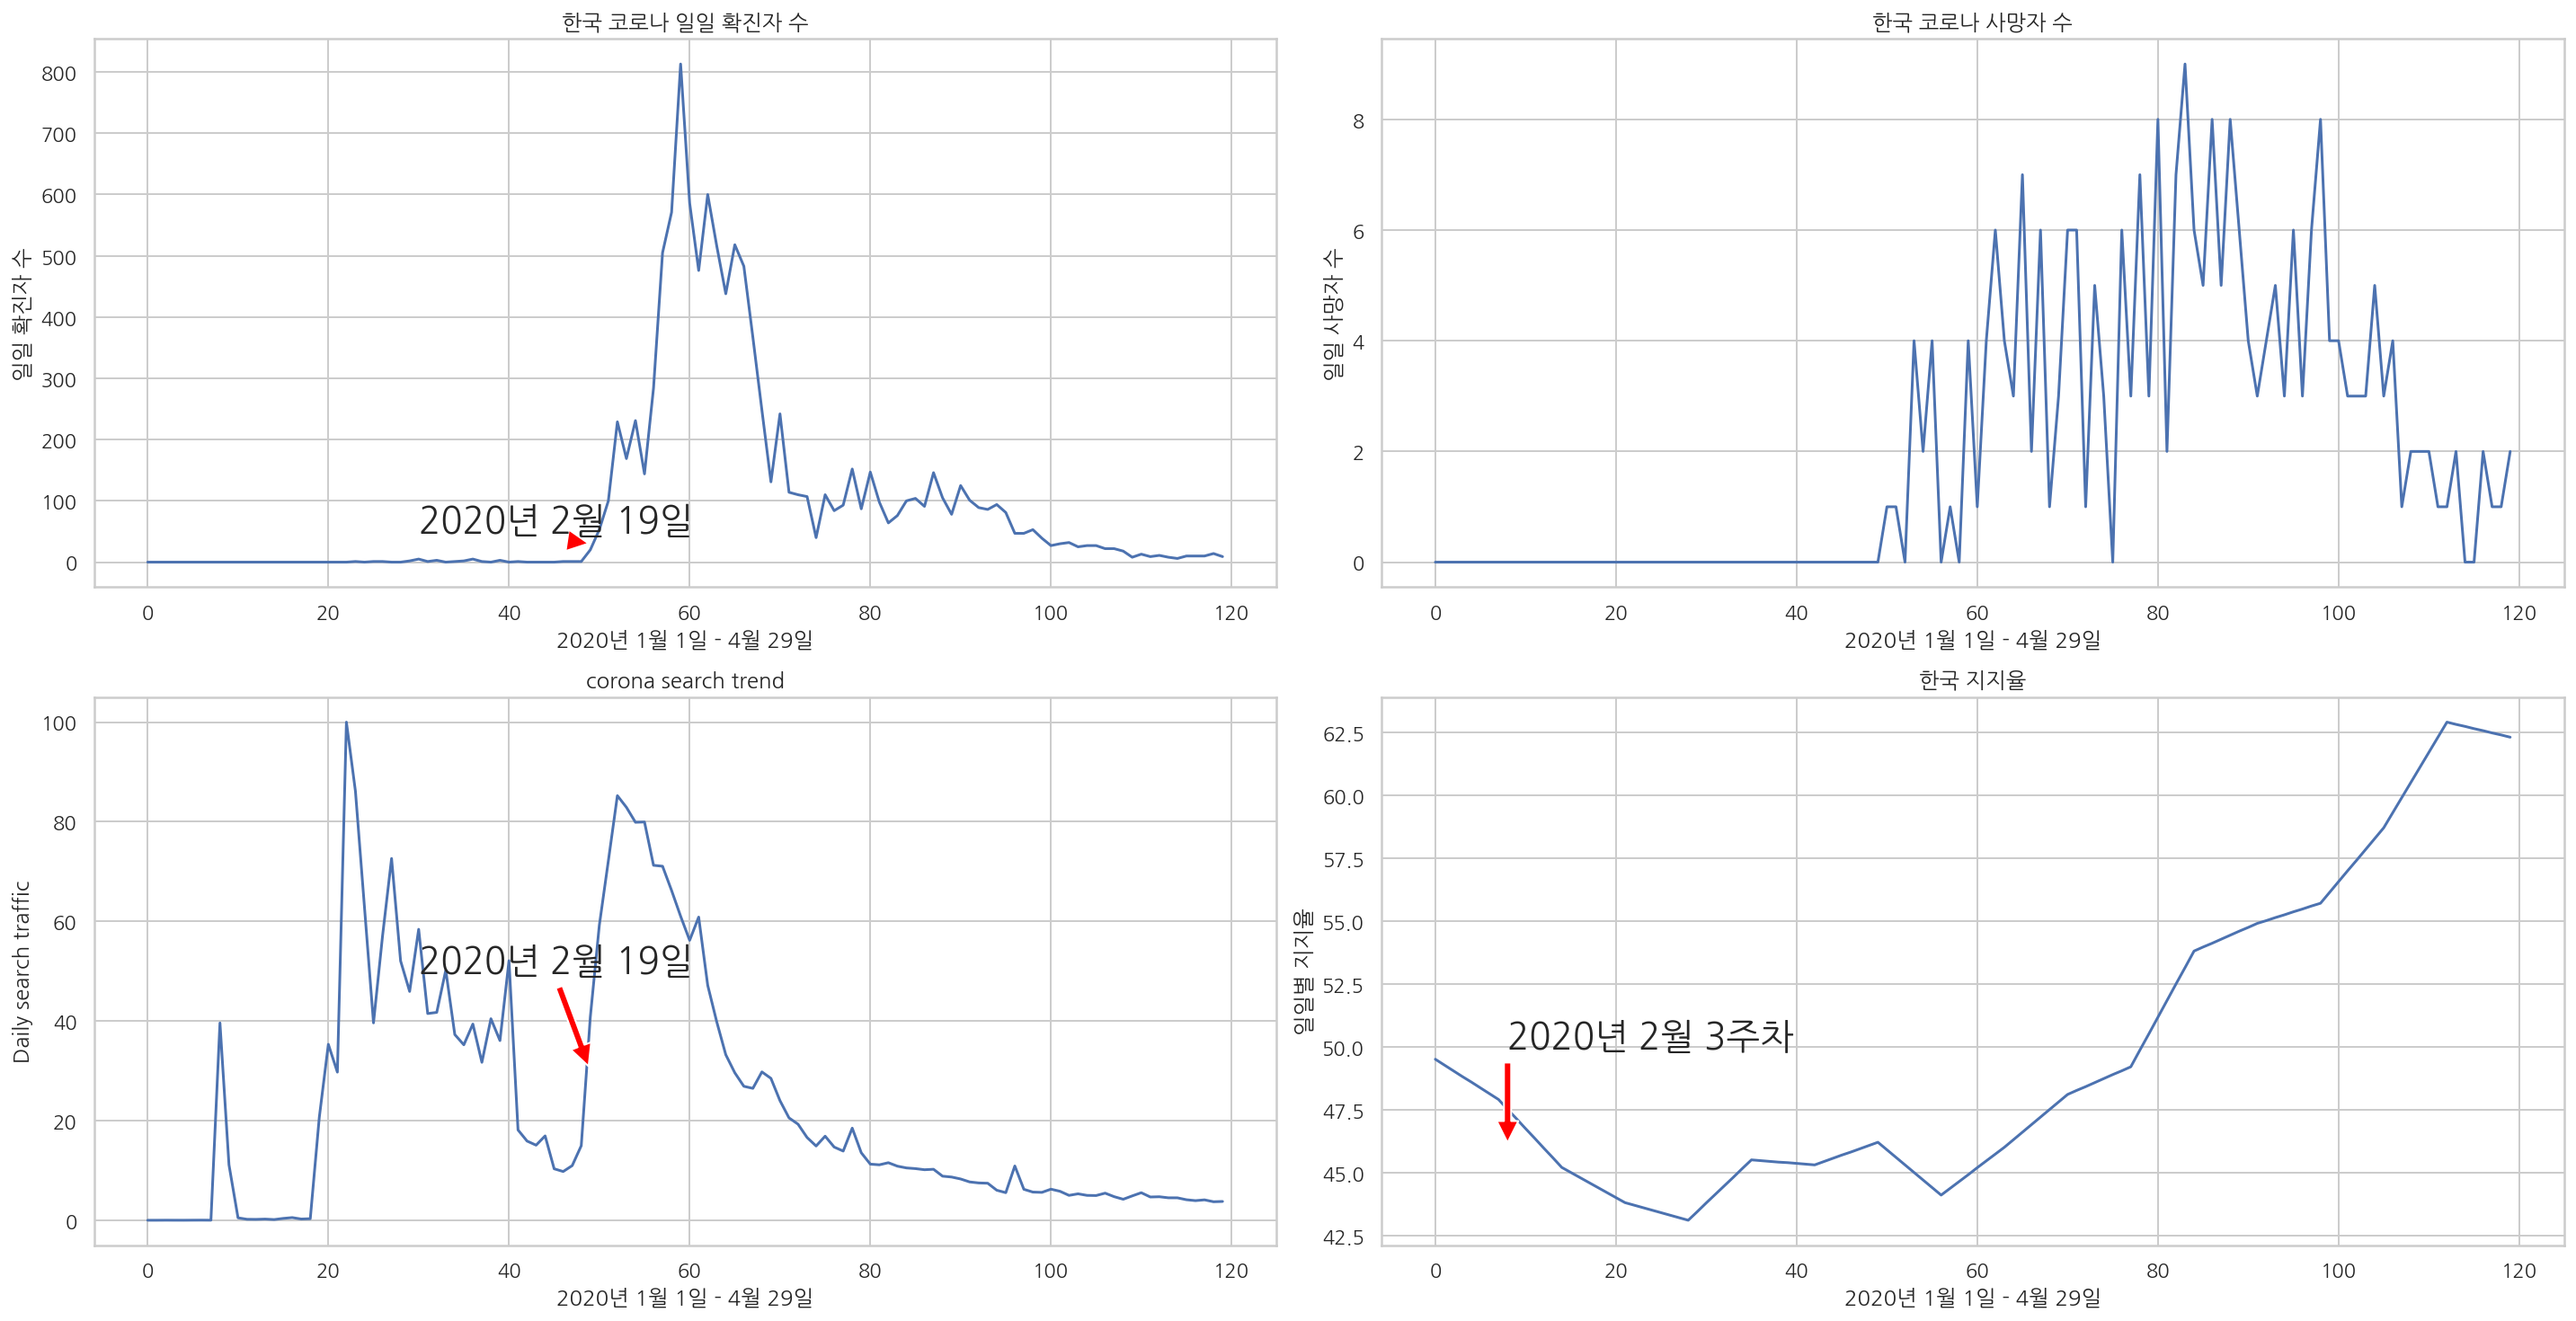

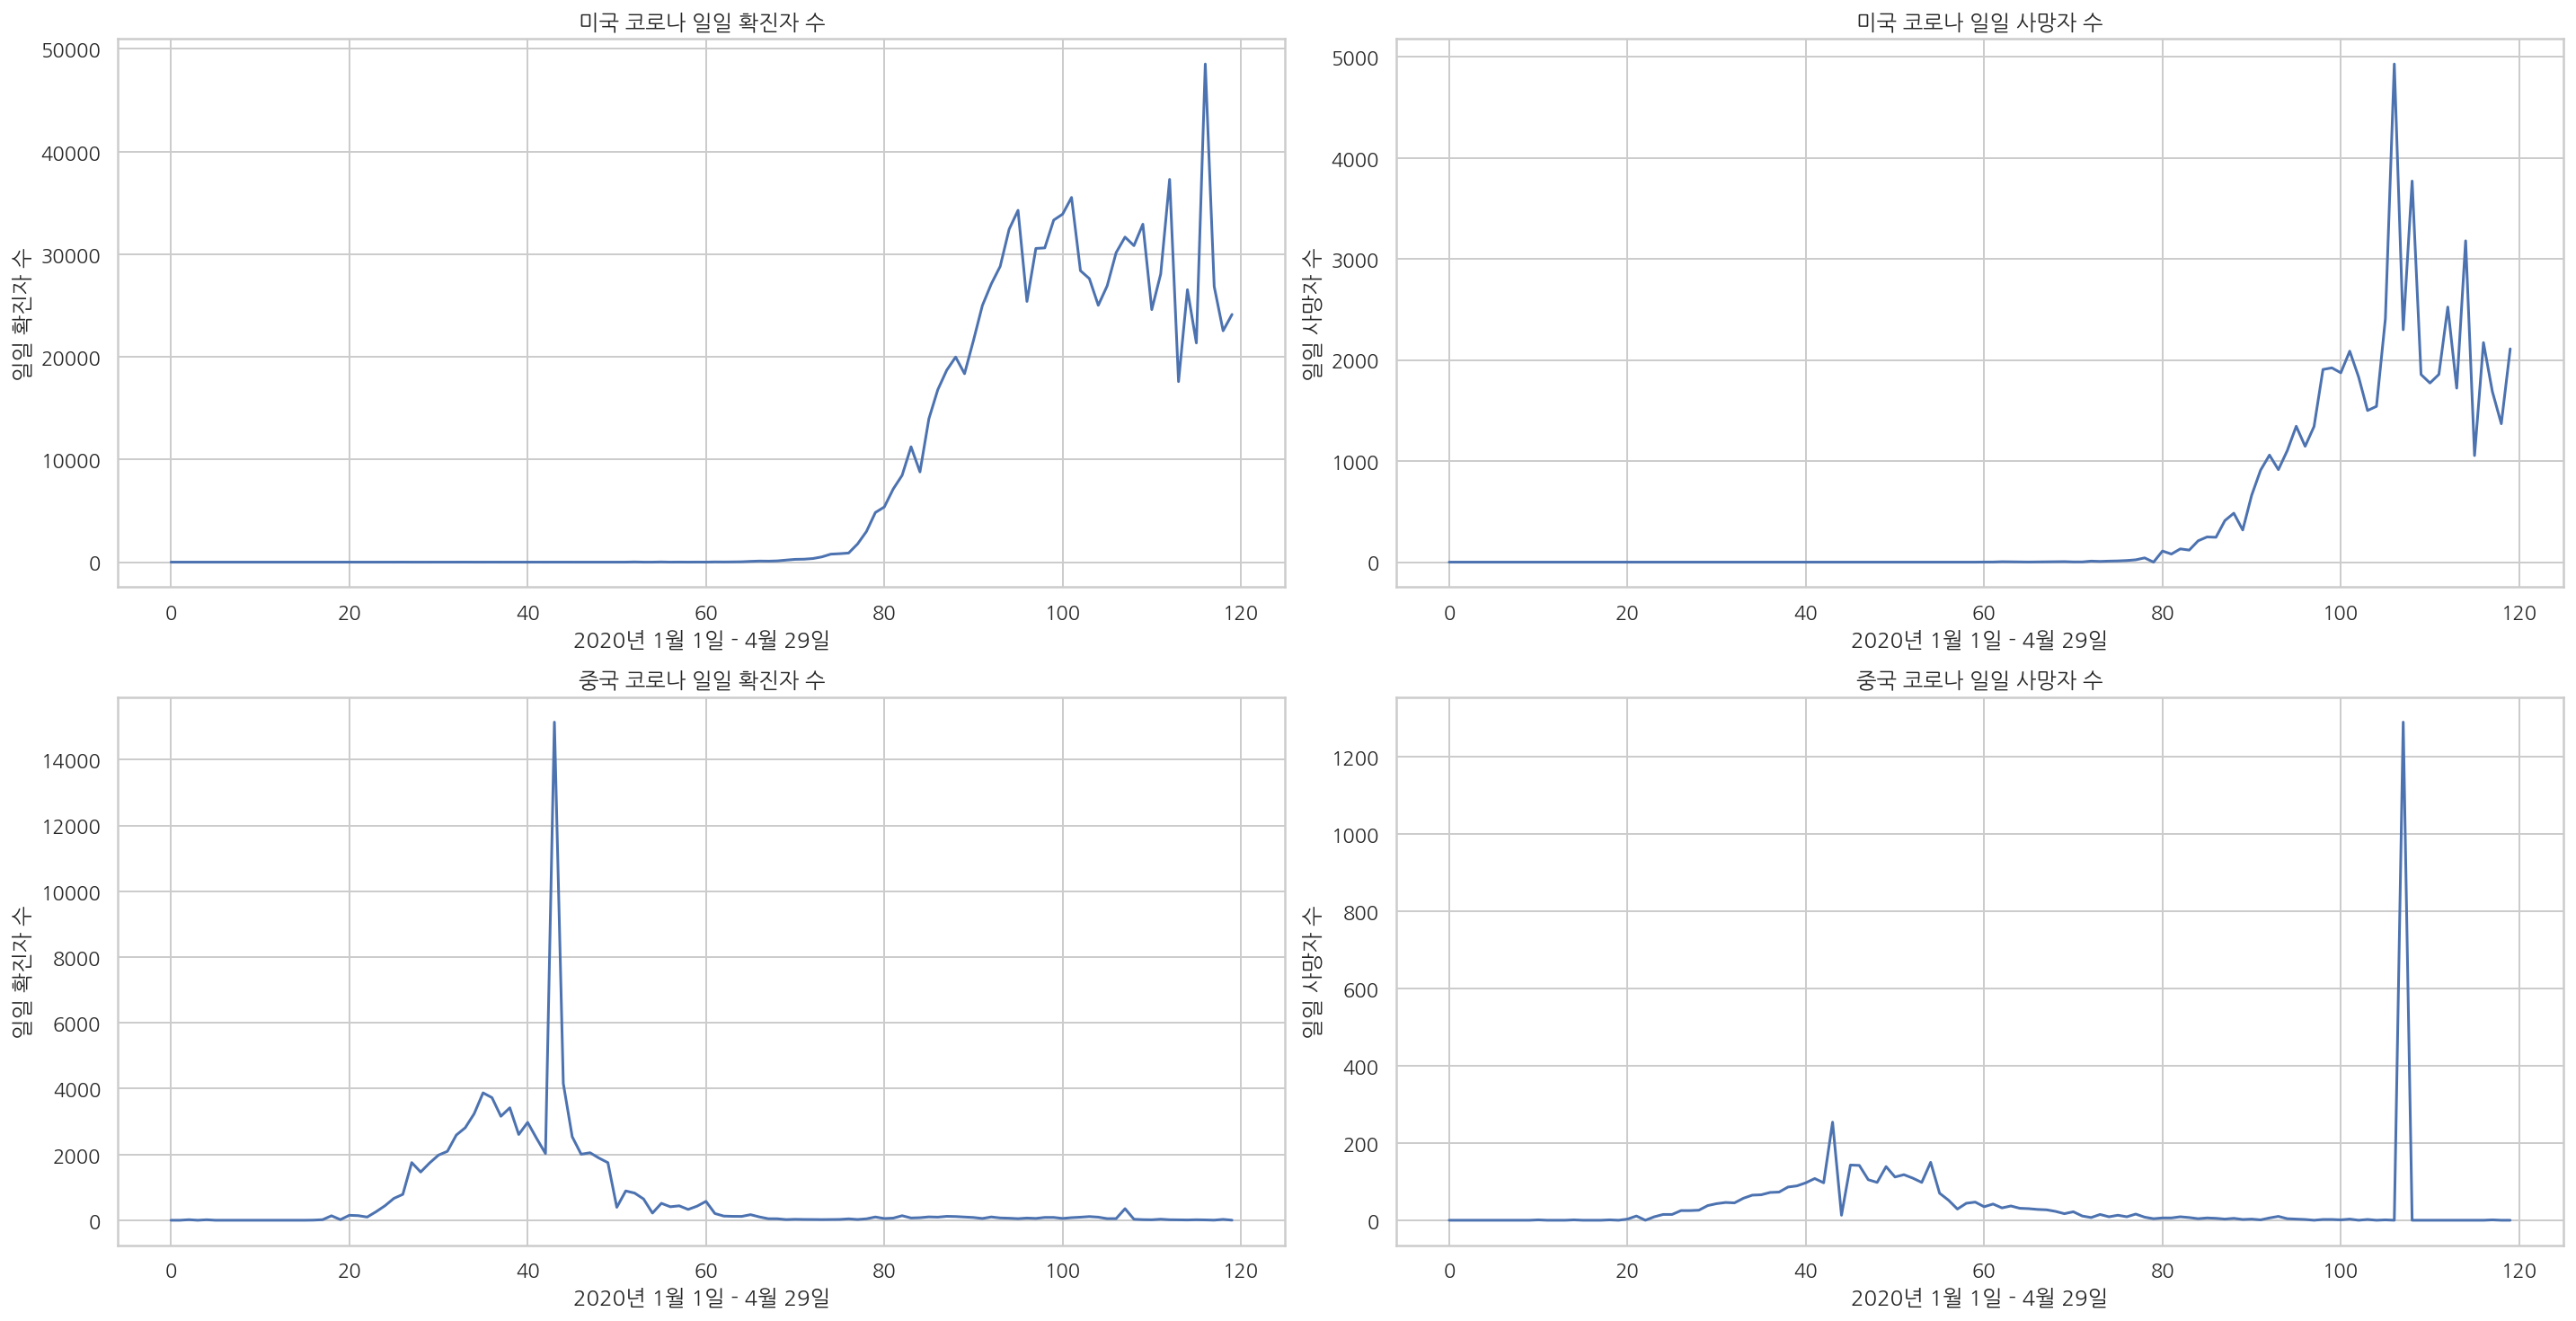

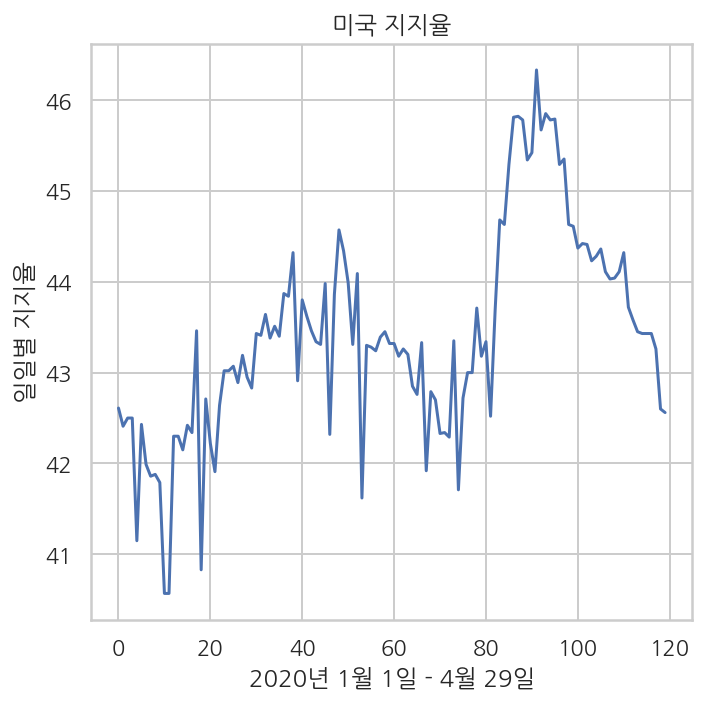

In [23]:
plt.figure(figsize=(20, 20), facecolor="1.")
plt.subplot(421)
plt.plot(corona_data["일일확진자(한)"])
plt.title("한국 코로나 일일 확진자 수")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일 확진자 수' )
plt.annotate("2020년 2월 19일", xy =(49,30), xytext = (30,50), fontsize=20, arrowprops=dict(facecolor = 'red', shrink = 0.05))

plt.subplot(422)
plt.plot(corona_data["일일사망자(한)"])
plt.title("한국 코로나 사망자 수")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일 사망자 수')

# 네이버 검색 트레픽 / 최고 트레픽 발생일을 100으로 기준

plt.subplot(423)
plt.plot(corona_data["search_trend"])
plt.title("corona search trend")
plt.ylabel("Daily search traffic")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.annotate("2020년 2월 19일", xy =(49,30), xytext = (30,50),fontsize=20, arrowprops=dict(facecolor = 'red', shrink = 0.05))

plt.subplot(424)

plt.plot(rate_T)
plt.title("한국 지지율")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일별 지지율' )
plt.annotate("2020년 2월 3주차", xy =(8,46), xytext = (8,50), fontsize=20,arrowprops=dict(facecolor = 'red', shrink = 0.05))

plt.tight_layout()

plt.figure(figsize=(20, 20), facecolor="1.")
plt.subplot(421)
plt.plot(corona_data["일일확진자(미)"])
plt.title("미국 코로나 일일 확진자 수")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일 확진자 수')

plt.subplot(422)
plt.plot(corona_data["일일사망자(미)"])
plt.title("미국 코로나 일일 사망자 수")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일 사망자 수')

plt.subplot(423)
plt.plot(corona_data["일일확진자(중)"])
plt.title("중국 코로나 일일 확진자 수")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일 확진자 수' )

plt.subplot(424)
plt.plot(corona_data["일일사망자(중)"])
plt.title("중국 코로나 일일 사망자 수")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일 사망자 수')

plt.tight_layout()

plt.figure(figsize=(5, 5), facecolor="1.")
plt.plot(daily_rate["미국지지율"])
plt.title("미국 지지율")
plt.xlabel('2020년 1월 1일 - 4월 29일')
plt.ylabel('일일별 지지율')

plt.tight_layout()
plt.show()

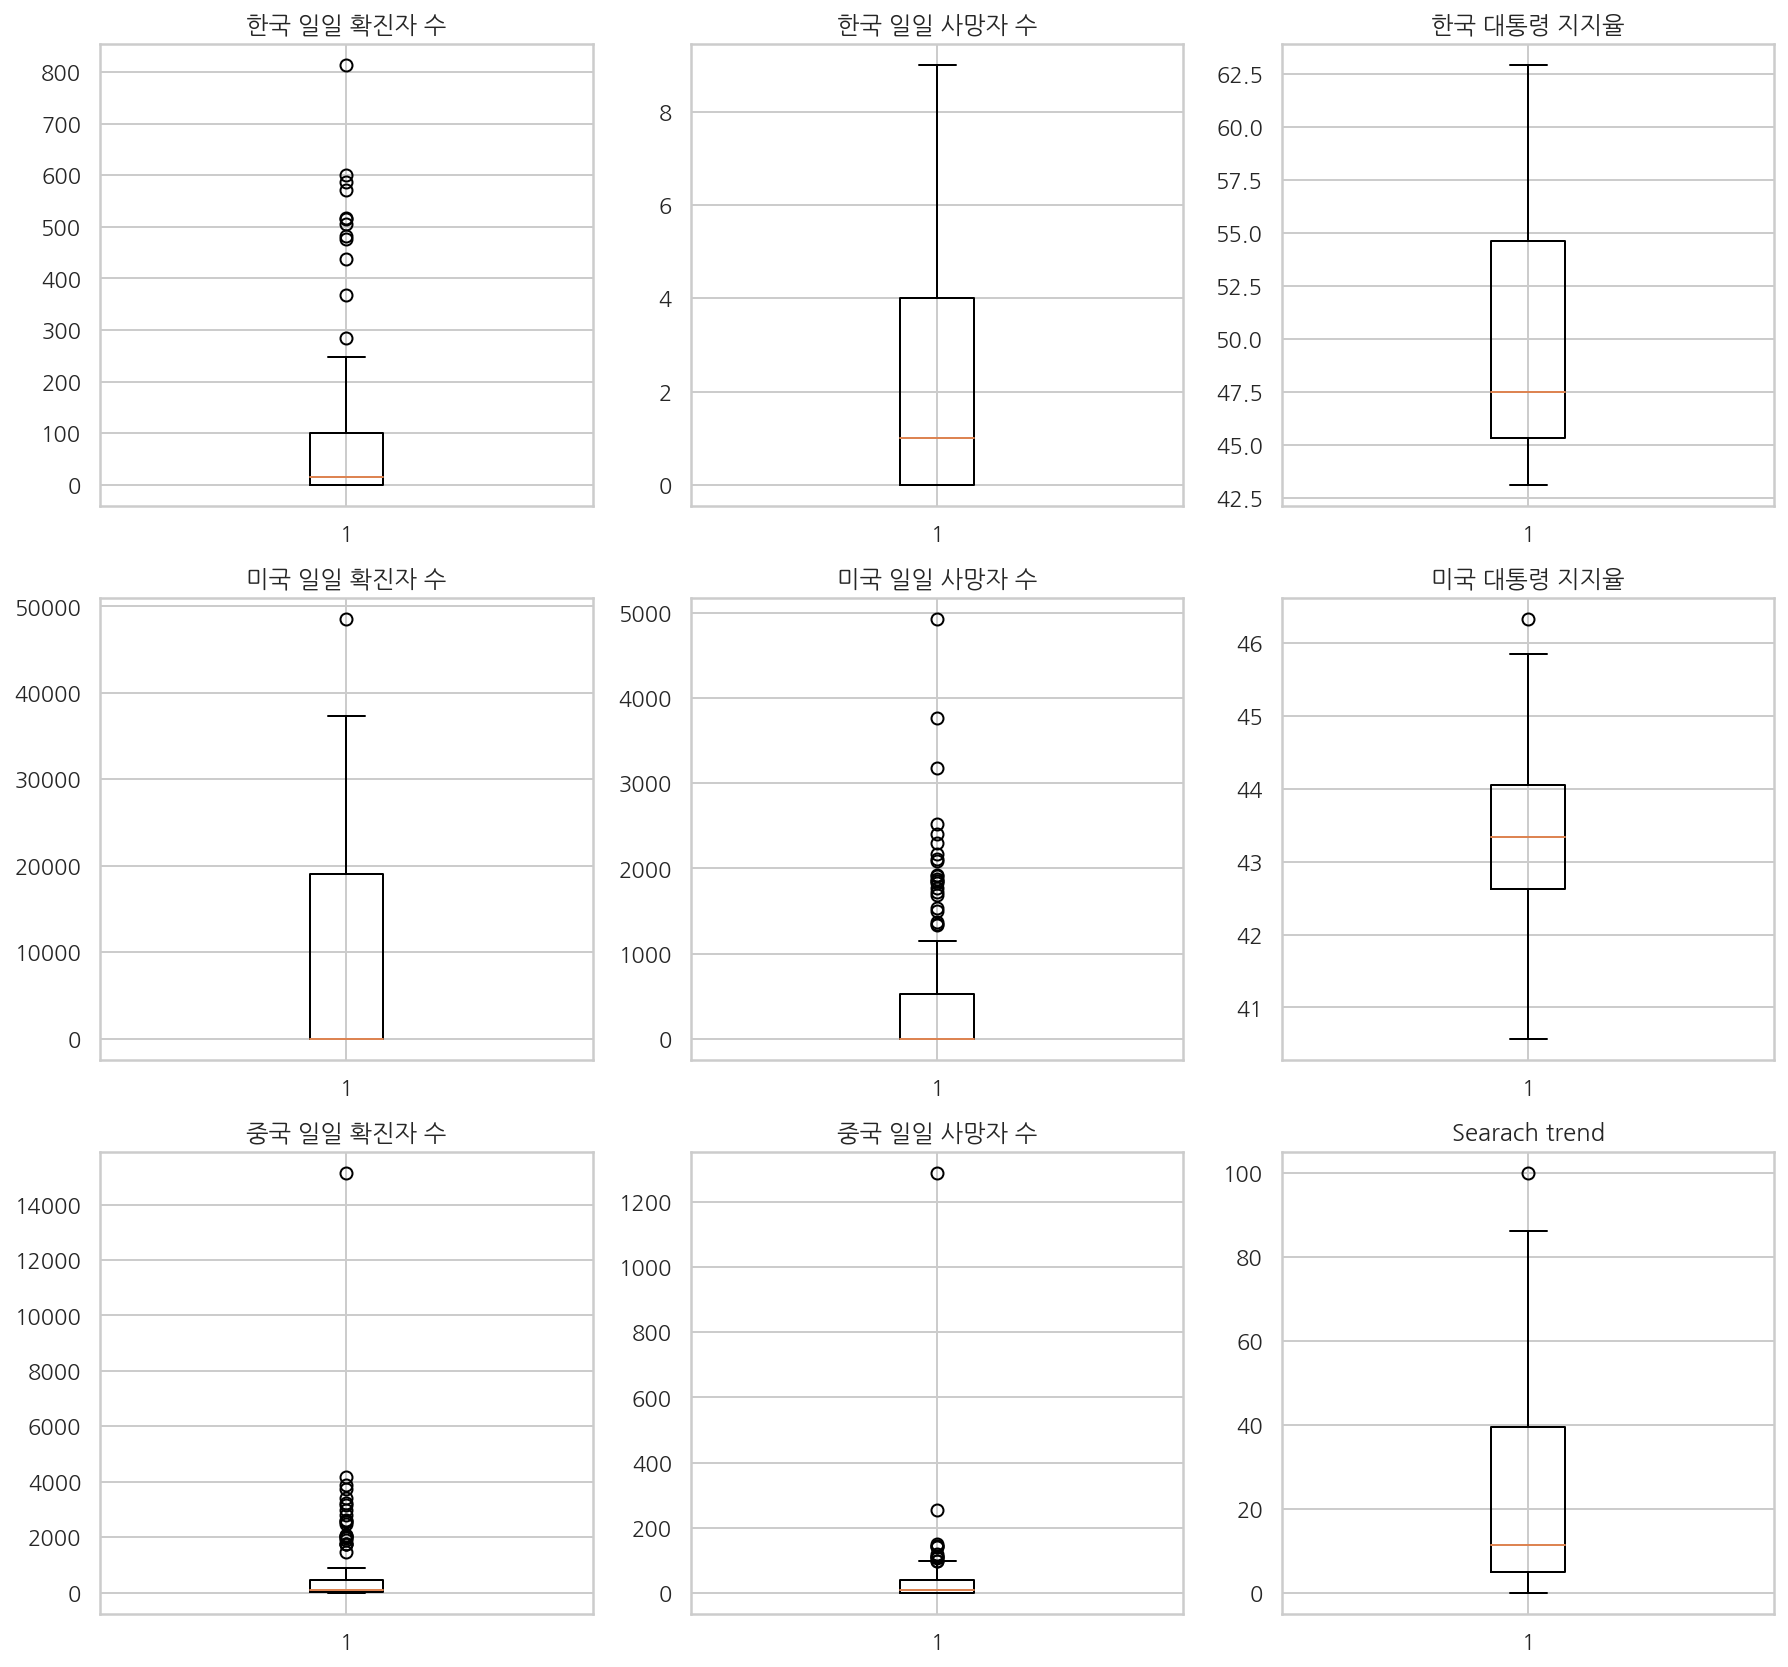

In [24]:
# 박스 플롯
plt.figure(figsize=(15, 45), facecolor="1.")

plt.subplot(931)
plt.boxplot(corona_data["일일확진자(한)"])
plt.title("한국 일일 확진자 수")

plt.subplot(932)
plt.boxplot(corona_data["일일사망자(한)"])
plt.title("한국 일일 사망자 수")

plt.subplot(933)
plt.boxplot(rate_T)
plt.title("한국 대통령 지지율")

plt.subplot(934)
plt.boxplot(corona_data["일일확진자(미)"])
plt.title("미국 일일 확진자 수")

plt.subplot(935)
plt.boxplot(corona_data["일일사망자(미)"])
plt.title("미국 일일 사망자 수")

plt.subplot(936)
plt.boxplot(daily_rate['미국지지율'])
plt.title("미국 대통령 지지율")

plt.subplot(937)
plt.boxplot(corona_data["일일확진자(중)"])
plt.title("중국 일일 확진자 수")

plt.subplot(938)
plt.boxplot(corona_data["일일사망자(중)"])
plt.title("중국 일일 사망자 수")

plt.subplot(939)
plt.boxplot(corona_data["search_trend"])
plt.title("Searach trend")

plt.show()

In [25]:
# 아웃라이어를 반환하는 함수
def out_lier(df, col):
    boxplot = df.describe()[col]
    IQR = boxplot["75%"] - boxplot["25%"]
    maxium = boxplot["75%"] + IQR * 1.5
    return df[df[col] > maxium]

In [26]:
# 한국 일일 확진자수 box plot 아웃라이어
out_lier(corona_data, "일일확진자(한)")

,날짜,search_trend,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중)
56,2020-02-26,71.26268,284,0,0,0,410,52
57,2020-02-27,71.07204,505,1,6,0,439,29
58,2020-02-28,66.20619,571,0,1,0,329,44
59,2020-02-29,61.04053,813,4,6,0,428,47
60,2020-03-01,56.20422,586,1,3,1,574,35
61,2020-03-02,60.86853,476,4,20,1,205,42
62,2020-03-03,47.17367,600,6,14,4,127,32
63,2020-03-04,39.84053,516,4,22,3,119,37
64,2020-03-05,33.24218,438,3,34,2,117,31
65,2020-03-06,29.61647,518,7,74,1,170,30


In [27]:
# 한국 일일 사망자 수 box plot 아웃라이어
out_lier(corona_data, "일일사망자(한)")

,날짜,search_trend,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중)


In [28]:
# 한국 대통령 지지율 box plot 아웃라이어
out_lier(daily_rate, "한국지지율")

,날짜,한국지지율,미국지지율


In [29]:
# 미국 일일 확진자 수 box plot 아웃라이어
out_lier(corona_data, "일일확진자(미)")

,날짜,search_trend,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중)
116,2020-04-26,3.95342,10,2,48529,2172,10,0


In [30]:
# 미국 일일 사망자 수 box plot 아웃라이어
out_lier(corona_data, "일일사망자(미)")

,날짜,search_trend,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중)
95,2020-04-05,5.55301,81,6,34272,1344,48,3
97,2020-04-07,6.23063,47,6,30561,1342,56,0
98,2020-04-08,5.67010,53,8,30613,1906,86,2
99,2020-04-09,5.61237,39,4,33323,1922,86,2
100,2020-04-10,6.25490,27,4,33901,1873,55,1
101,2020-04-11,5.82991,30,3,35527,2087,79,3
102,2020-04-12,5.00848,32,3,28391,1831,93,0
103,2020-04-13,5.32111,25,3,27620,1500,112,2
104,2020-04-14,5.00666,27,5,25023,1541,94,0
105,2020-04-15,4.97503,27,3,26922,2408,49,1


In [31]:
# 미국 대통령 지지율 box plot 아웃라이어
out_lier(daily_rate, "미국지지율")

,날짜,한국지지율,미국지지율
91,2020-04-01,54.9,46.33


In [32]:
# 중국 일일 확진자 수 box plot 아웃라이어
out_lier(corona_data, "일일확진자(중)")

,날짜,search_trend,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중)
27,2020-01-28,72.63073,0,0,0,0,1753,25
28,2020-01-29,52.06261,0,0,0,0,1466,26
29,2020-01-30,45.93889,2,0,0,0,1740,38
30,2020-01-31,58.41870,5,0,1,0,1980,43
31,2020-02-01,41.50730,1,0,1,0,2095,46
32,2020-02-02,41.73647,3,0,1,0,2590,45
33,2020-02-03,50.19940,0,0,3,0,2812,57
34,2020-02-04,37.28806,1,0,0,0,3237,65
35,2020-02-05,35.23094,2,0,0,0,3872,66
36,2020-02-06,39.39590,5,0,1,0,3727,72


In [33]:
# 중국 일일 사망자 수 box plot 아웃라이어
out_lier(corona_data, "일일사망자(중)")

,날짜,search_trend,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중)
41,2020-02-11,18.13918,1,0,1,0,2490,108
43,2020-02-13,15.08472,0,0,1,0,15141,254
45,2020-02-15,10.34468,0,0,0,0,2538,143
46,2020-02-16,9.79906,1,0,0,0,2007,142
47,2020-02-17,10.98521,1,0,0,0,2052,105
48,2020-02-18,14.97945,1,0,0,0,1890,98
49,2020-02-19,40.75986,20,0,0,0,1750,139
50,2020-02-20,59.21885,53,1,0,0,394,112
51,2020-02-21,72.15665,100,1,1,0,891,118
52,2020-02-22,85.23907,229,0,19,0,826,109


In [34]:
# 한국 Search trend box plot 아웃라이어
out_lier(corona_data, "search_trend")

,날짜,search_trend,일일확진자(한),일일사망자(한),일일확진자(미),일일사망자(미),일일확진자(중),일일사망자(중)
22,2020-01-23,100.0,0,0,0,0,97,0


In [67]:
# 데이터 스케일링(정규화)
def scaling(X):
    return (X-X.min())/(X.std())

def normalized(df, confirmed, deceased):
    normalize = {}
    normalize["일일 확진자 수"] = scaling(df[confirmed])
    normalize["일일 사망자 수"] = scaling(df[deceased])
    return pd.DataFrame(normalize)
    

normalize = normalized(corona_data, "일일확진자(한)", "일일사망자(한)")
normalize["Search_Trend"] = scaling(corona_data["search_trend"])
rate_kor = scaling(rate_T / 100)


normalize_usa = normalized(corona_data, "일일확진자(미)", "일일사망자(미)")
rate_usa = scaling(daily_rate["미국지지율"] / 100)

normalize_chn = normalized(corona_data, "일일확진자(중)", "일일사망자(중)")


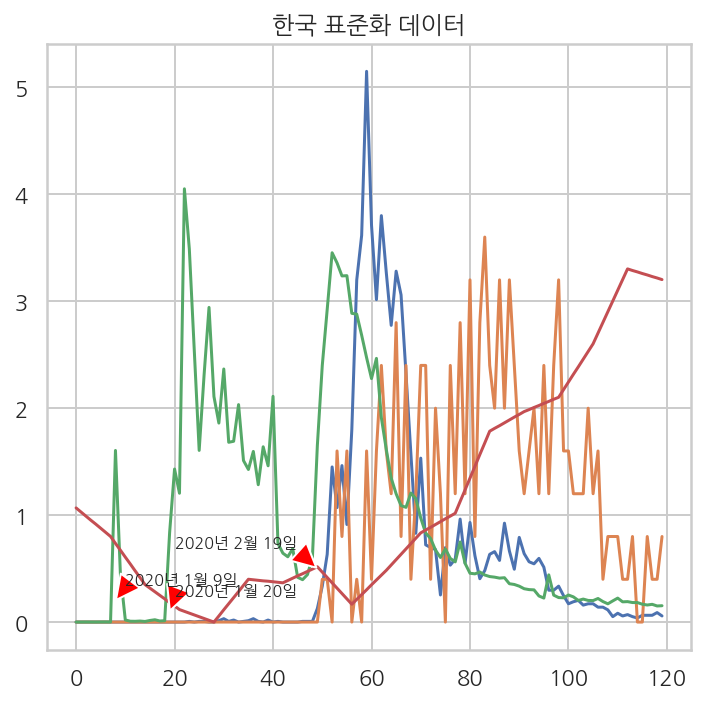

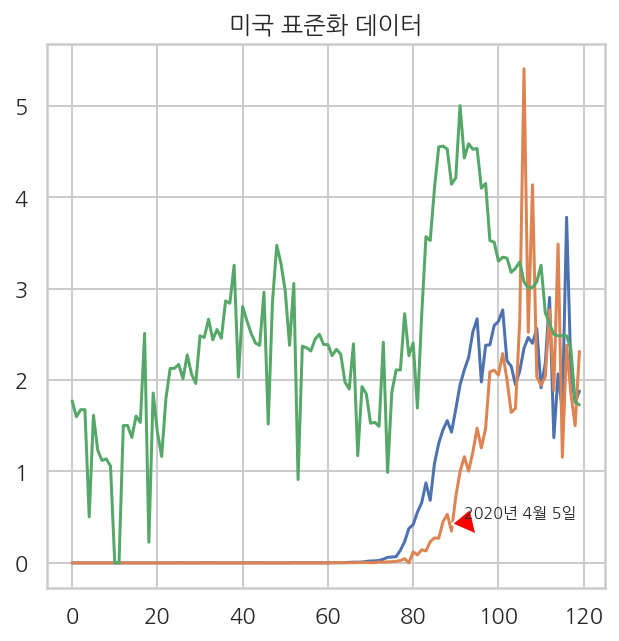

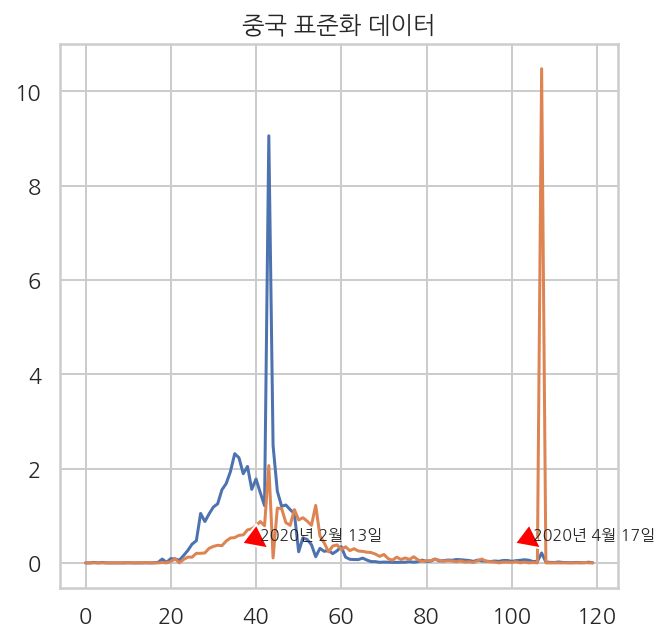

In [68]:
# 스케이링 데이터 그래프화 
plt.figure(figsize=(5, 5), facecolor="1.")
plt.title("한국 표준화 데이터")
plt.plot(normalize)
plt.annotate("2020년 2월 19일", xy =(49,0.5), xytext = (20,0.7),fontsize=8, arrowprops=dict(facecolor = 'red', shrink = 0.05))
plt.annotate("2020년 1월 20일", xy =(19,0.1), xytext = (20,0.25),fontsize=8, arrowprops=dict(facecolor = 'red', shrink = 0.05))
plt.annotate("2020년 1월 9일", xy =(8,0.2), xytext = (10,0.35),fontsize=8, arrowprops=dict(facecolor = 'red', shrink = 0.05))

plt.plot(rate_kor)
plt.tight_layout()

plt.figure(figsize=(5, 5), facecolor="1.")
plt.title("미국 표준화 데이터")
plt.annotate("2020년 4월 5일", xy =(95,0.3), xytext = (92,0.5),fontsize=8, arrowprops=dict(facecolor = 'red', shrink = 0.05))
plt.plot(normalize_usa)
plt.plot(rate_usa)

plt.figure(figsize=(5, 5), facecolor="1.")
plt.title("중국 표준화 데이터")
plt.annotate("2020년 2월 13일", xy =(43,0.3), xytext = (41,0.5),fontsize=8, arrowprops=dict(facecolor = 'red', shrink = 0.05))
plt.annotate("2020년 4월 17일", xy =(107,0.3), xytext = (105,0.5),fontsize=8, arrowprops=dict(facecolor = 'red', shrink = 0.05))
plt.plot(normalize_chn)
plt.show()

#2020년 1월 9일 : 우한 코로나 첫 사망자 발생
#2020년 1월 20일 : 국내 첫 코로나 환자 발생
#2020년 2월 12일 : 우한 페렴 명칭 코로나 바이러스로 변경.
#2020년 2월 19일 : 국내 코로나 첫 사망자 발생

# 한국 기준
# 초록색 : 코로나 검색 트레픽
# 파란색 : 코로나 일일 확진자 수
# 주황색 : 일일 사망자 수
# 빨간색 : 한국 대통령 지지율

# 미국 기준
# 초록색 : 미국 대통령 지지율
# 파란색 : 코로나 일일 확진자 수
# 주황색 : 코로나 일일 사망자 수

# 중국 기준
# 파란색 : 코로나 일일 확진자 수
# 주황색 : 코로나 일일 사망자 수

In [69]:
normalize["일일 확진자 수(미)"] = normalize_usa['일일 확진자 수']
normalize["일일 사망자 수(미)"] = normalize_usa['일일 사망자 수']
normalize["일일 확진자 수(중)"] = normalize_chn['일일 확진자 수']
normalize["일일 사망자 수(중)"] = normalize_chn['일일 사망자 수']

normalize["한국지지율"] = scaling(daily_rate['한국지지율'])
normalize["미국지지율"] = scaling(daily_rate['미국지지율'])

In [70]:
normalize = normalize.drop(normalize.index[0:49])
normalize_split = normalize
normalize_split.reset_index(drop=True, inplace=True)

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = normalize_split[["일일 확진자 수", "일일 사망자 수", "Search_Trend", "일일 확진자 수(미)", "일일 사망자 수(미)",
                    "일일 확진자 수(중)", "일일 사망자 수(중)","미국지지율"]]
y = normalize_split[["한국지지율"]]


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round()

,VIF Factor,features
0,3.0,일일 확진자 수
1,4.0,일일 사망자 수
2,6.0,Search_Trend
3,15.0,일일 확진자 수(미)
4,6.0,일일 사망자 수(미)
5,3.0,일일 확진자 수(중)
6,1.0,일일 사망자 수(중)
7,16.0,미국지지율


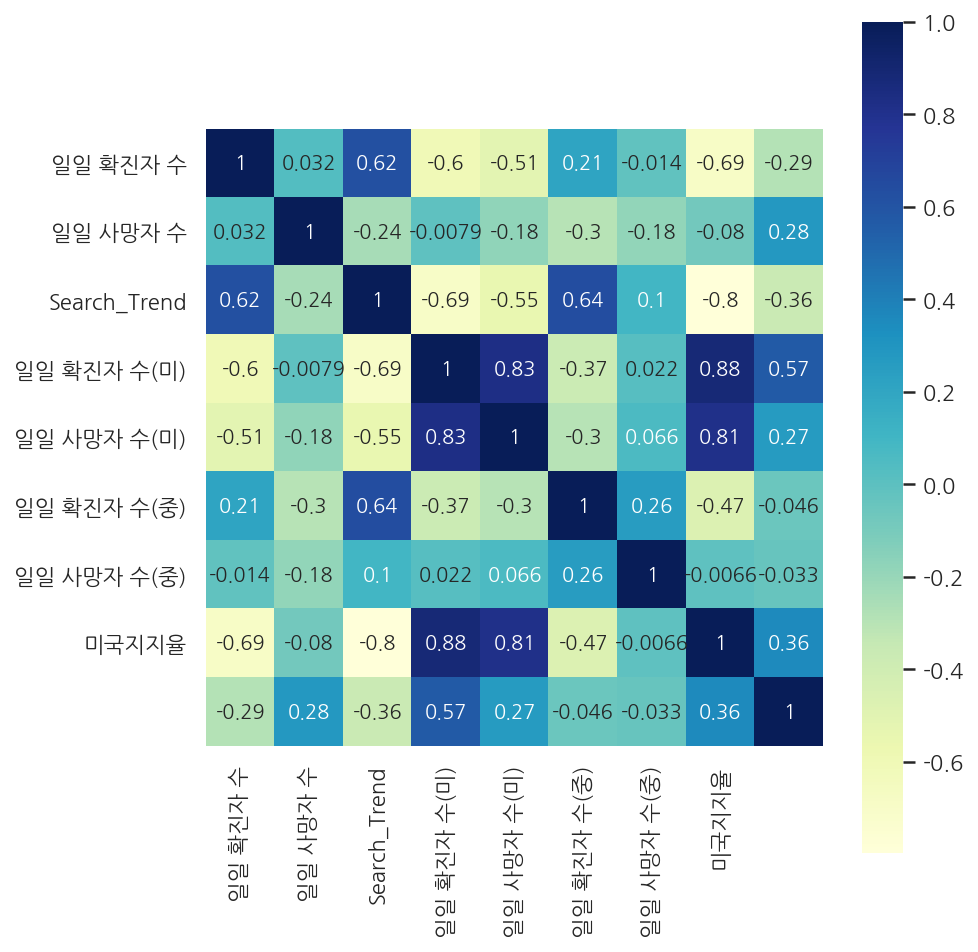

In [72]:
import seaborn as sns
corr = normalize_split.corr(method = 'pearson')

plt.figure(figsize=(7, 7), facecolor="1.")
plt.rc('font', family='AppleGothic')
show_cols = ["일일 확진자 수", "일일 사망자 수", "Search_Trend", "일일 확진자 수(미)", "일일 사망자 수(미)",
                    "일일 확진자 수(중)", "일일 사망자 수(중)","미국지지율"]
sns.heatmap(corr.values, cbar=True, annot=True, cmap="YlGnBu",square=True, yticklabels=show_cols,
           xticklabels = show_cols)

plt.tight_layout()
plt.show()

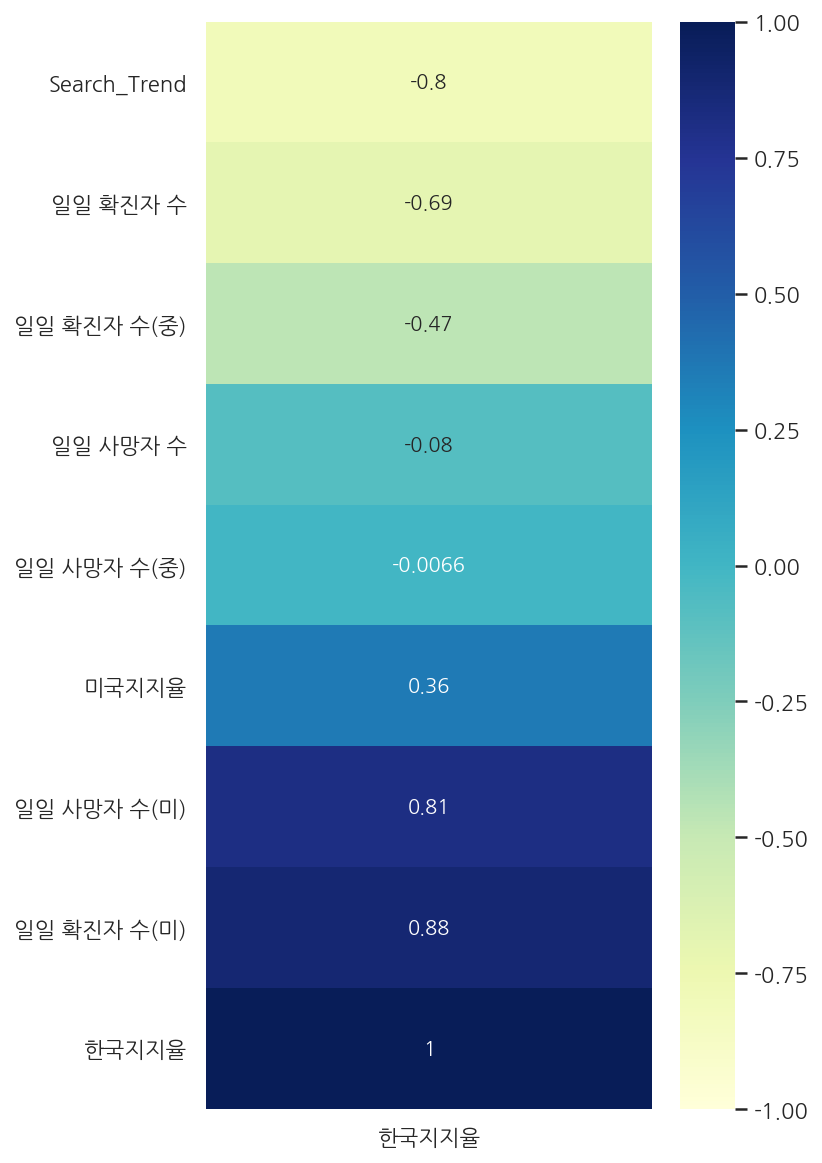

In [73]:
plt.figure(figsize=(5,10), facecolor="1.")
sns.heatmap(normalize_split.corr()[['한국지지율']].sort_values(by=['한국지지율'],ascending=True).head(50), cmap="YlGnBu", vmin=-1, annot=True);

In [76]:
normalize_split.profile_report()

AttributeError: 'DataFrame' object has no attribute 'profile_report'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [ ]:
X_train = X.loc[:25]
X_test = X.loc[25:]
y_train = y.loc[:25]
y_test = y.loc[25:]
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

print(len(X), len(y))

In [ ]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

In [ ]:
a = np.array(X["일일 확진자 수"])
b = np.array(X["일일 사망자 수"])
c = np.array(X["Search_Trend"])
d = np.array(X["일일 확진자 수(미)"])
e = np.array(X["일일 사망자 수(미)"])
f = np.array(X["일일 확진자 수(중)"])
g = np.array(X["일일 사망자 수(중)"])
h = np.array(X["미국지지율"])


j = np.array(y["한국지지율"])

plt.figure(figsize  = (20,20), facecolor="1.")

plt.subplot(8,4,1)
plt.scatter(j,a)
plt.xlabel("일일 확진자 수")
plt.ylabel("한국지지율")


plt.subplot(8,4,2)
plt.scatter(j,b)
plt.xlabel("일일 사망자 수")
plt.ylabel("한국지지율")


plt.subplot(8,4,3)
plt.scatter(j,c)
plt.xlabel("Search_Trend")
plt.ylabel("한국지지율")


plt.subplot(8,4,4)
plt.scatter(j,d)
plt.xlabel("일일 확진자 수(미)")
plt.ylabel("한국지지율")


plt.subplot(8,4,5)
plt.scatter(j,e)
plt.xlabel("일일 사망자 수(미)")
plt.ylabel("한국지지율")

plt.subplot(8,4,6)
plt.scatter(j,f)
plt.xlabel("일일 확진자 수(중)")
plt.ylabel("통합 지지율")


plt.subplot(8,4,7)
plt.scatter(j,g)
plt.xlabel("일일 사망자 수(중)")
plt.ylabel("한국지지율")


plt.subplot(8,4,8)
plt.scatter(j,h)
plt.xlabel("미국지지율")
plt.ylabel("한국지지율")

plt.tight_layout()
plt.show()

[Text(0, 0, 'const'),
 Text(0, 0, '일일 확진자 수'),
 Text(0, 0, '일일 사망자 수'),
 Text(0, 0, 'Search_Trend'),
 Text(0, 0, '일일 확진자 수(미)'),
 Text(0, 0, '일일 사망자 수(미)'),
 Text(0, 0, '일일 확진자 수(중)'),
 Text(0, 0, '일일 사망자 수(중)'),
 Text(0, 0, '미국지지율')]

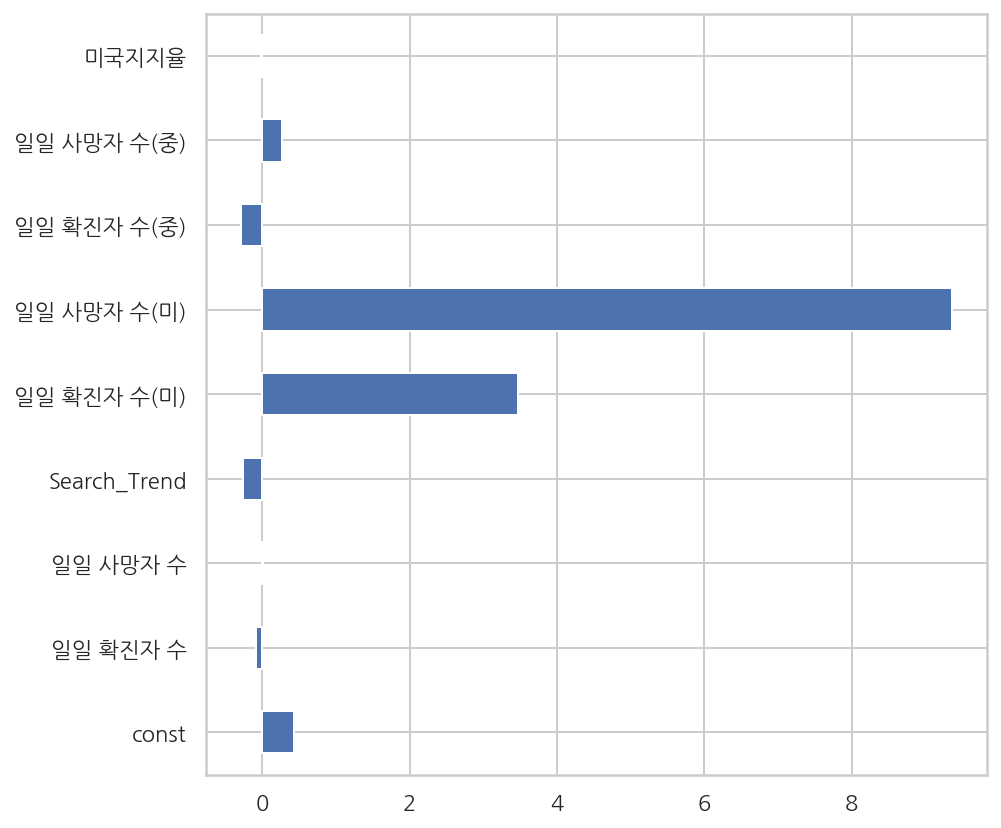

In [75]:
mpl.rc('font',family='AppleGothic')
plt.figure(facecolor="1.")
plt.rcParams['figure.figsize'] = [7,7]

coefs = model.params.tolist()
coef_series = pd.Series(coefs)
y_labels = model.params.index.tolist()

ax = coef_series.plot(kind = 'barh')
ax.set_yticklabels(y_labels)